In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab03.ipynb")

ModuleNotFoundError: No module named 'otter'

# Lab 3:  Bayesian Estimation in Hierarchical Graphical Models
Welcome to the third Data 102 lab! 

The goal of this lab is to go over Bayesian Estimation and provide an introduction to Hierarchial Graphical Models.

The code and responses you need to fill in are represented by `...`. There is additional documentation for each part as you go along. 


## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Gradescope Submission
To submit the lab: 
1. Navigate to Kernel > Restart & Run All. Ensure that all public test cases pass locally. 
2. Save your notebook under File > Save and Checkpoint. If you do not save your notebook, then you might run into issues with the downloaded .zip file.
3. Run the very last cell, which generates a .zip file for you to download to your local machine. Click the “here” button to download the .zip file. You may receive an error that the .zip file was unable to be created because there was an issue with PDF generation. You need to ensure that you’ve answered all of the questions that require a manual response.
4. If your work downloads as several independent files rather than as a .zip, you are likely using Safari on a Mac. Follow these instructions to make sure you can download your work as a zip: https://macreports.com/how-to-download-zip-files-without-unzipping/
5. Upload this .zip to the correct assignment on Gradescope. After submitting, the autograder built-in to the Gradescope assignment will tell you which public test cases you’ve passed and failed. There are no hidden test cases.

**For full credit, this assignment should be completed and submitted before Thursday, September 22, 2022 at 11:59 PM. PT**

## Collaborators
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta, binom
import itertools
from ipywidgets import interact, interactive


import hashlib
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

def get_hash(num, significance = 4):
    num = round(num, significance)
    """Helper function for assessing correctness"""
    return hashlib.md5(str(num).encode()).hexdigest()

import pymc3 as pm
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.INFO)

ModuleNotFoundError: No module named 'matplotlib'

## Question 1: Beta-Binomial Graphical Model

In this question we will look at the COVID modeling example. Here's the summary of what you need to know:

In this problem we are trying to estimate the COVID infection risk in households. To do that we curate a list of K studies. Each study has an associated pair $(N_i, X_i)$ where $N_i$ denotes the number of susceptible individuals considered and $X_i$ is the number of them that became infected. In our modeling assumptions we assume that each susceptible person gets infected with probability $\theta_i$. In epidemiology, this quantity is known as Secondary Attack Rate, or SAR for short.

We're trying to do two things: 
1. We want to *combine* the information from all the studies, so we can get a better estimate of SAR than we would with any individual study on its own. 
2. We want to understand why the studies got different results: specifically, we'd like to figure out the regions with the *lowest* SAR, so that we can investigate what contributed to their relative success. In the other direction, we want to know which regions had the *highest* SAR, since they're likely the ones most urgently in need of intervention measures to help slow the spread.


In [4]:
# Read out a dataset 
study_df = pd.read_csv("study_df.csv", header=0)
study_df

,Name,X,N
0,Study 0,3,8
1,Study 1,2,11
2,Study 2,6,12
3,Study 3,9,27
4,Study 4,11,38
5,Study 5,21,59
6,Study 6,27,79
7,Study 7,23,82
8,Study 8,26,120
9,Study 9,57,145


### 1.a Compute the trivial estimate of SAR


The most straightforward way to estimate the probability of infection (SAR) is to divide the number of infected cases by the number of susceptible cases. 

Compute this quantity in the cell below.

<!--
BEGIN QUESTION
name: q1a
manual: false
points: 1
-->

In [5]:
# TODO: Complete the function
def trivial_theta_estimate(N_value, X_value):
    """
    Computes the trivial estimate of the Secondary Attack Rate
    
    Inputs:
        N_value : int, number of susceptible individuals
        X_value : int, number of infected individuals
        
    Output:
        theta_est : float, estimate of probability of infection (SAR)
    """
    theta_est = X_value/N_value # SOLUTION
    return theta_est

In [7]:
grader.check("q1a")

q1a results: All test cases passed!

In [8]:
# Apply  'trivial_theta_estimate' to each row of the dataframe and add a new column to hold the result
study_df['Trivial estimate'] = study_df.apply(lambda row: trivial_theta_estimate(row['N'], row['X']), axis =1)
study_df.sort_values('Trivial estimate')

,Name,X,N,Trivial estimate
1,Study 1,2,11,0.181818
8,Study 8,26,120,0.216667
7,Study 7,23,82,0.280488
4,Study 4,11,38,0.289474
3,Study 3,9,27,0.333333
6,Study 6,27,79,0.341772
5,Study 5,21,59,0.355932
11,Study 11,122,341,0.357771
0,Study 0,3,8,0.375000
9,Study 9,57,145,0.393103


**Trivial estimates suggest that both minimum and maximum probabilities of infection correspond to small studies.**

|      | Min     | Max     |
|------|---------|---------|
| Name | Study 1 | Study 2 |
| X    | 2       | 8       | 
| N    | 11      | 12      |
|$\theta$| 0.18  | 0.50    |


Intuitively, we probably shouldn't be making policy decision based on such small studies alone, especially when this dataset has other studies with tens or even hundreds of people. We would like to balance between strong evidence from the small studies and high confidence in estimates from larger studies.

Bayesian inference provides a flexible framework to balance our a priori beliefs with new evidence. Consider the following graphical model:


![](model.png)


The circles represent random variables, and shaded circles represent observed random variables. The diamond at the top represents fixed, unknown parameters . You'll also see people draw dots or squares for these: there isn't really one consistent notation.

Here are a few important quantities in Bayesian inference. This lingo will be used at length in this course and in anything you'll learn in the future about Bayesian inference, so make sure you get familiar with it.  



### Joint Density / Joint Distribution:
The structure of the graphical model specified the full joint density of the parameters and data in the model. For this example the join density is:
$$p(\theta_1, \theta_2, \ldots, \theta_K, X_1, \ldots, X_K) = \prod_{\text{vertex $V$ in graph}}p(V|\text{parent of $V$}) = \prod_{i=1}^K \underbrace{p(\theta_i|\alpha, \beta)}_{\text{prior of $\theta_i$}} \prod_{i=1}^K \underbrace{p(X_i|\theta_i)}_{\text{likelihood of data $X_i$}}$$

The factorization of the joint density into products of priors and likelihoods is the key feature of Hierarchical Models. It allows to take a complex $2K$-dimensional joint probability and factorize it into products of 1-dimensional probabilities. This factorization is useful because it lets us simplify the distribution and control the amount of computation we have to do.



### Prior:  $\theta_i \sim Beta(\alpha, \beta)$

We have the prior distribution:

\begin{align}
p(\theta_i) 
    &= \theta_i^{\alpha-1}(1-\theta_i)^{\beta-1} \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \\
    &\propto_{\theta_i}\theta_i^{\alpha-1}(1-\theta_i)^{\beta-1}
\end{align}

where $\Gamma$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function). Since $\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}$ does not depend on the value of $\theta$. It is a scaling factor that ensures that $p(\theta_i)$ is a valid probability function. This leads to a common notation in practice: $p(\theta_i)\propto_{\theta_i}\theta_i^{\alpha-1}(1-\theta_i)^{\beta-1}$. The symbol $\propto_{\theta_i}$ means proportional in $\theta_i$. This is a little more explicit than the $\propto$ notation that you usually see.



### Likelihood: $X_i|\theta \sim Binomial(N_i, \theta_i)$

We'll use the notation $p(X_i|\theta)$ for the likelihood function, which represents our belief about the distribution of the data if we know what the parameter $\theta$ is (in other words, if we condition on $\theta$).
$$p(X_i|\theta_i) = \binom{N_i}{X_i} \theta_i^{X_i}(1-\theta_i)^{N_i - X_i}$$

### Marginal: Unconditional distribution of $X_i$:

\begin{align}
p(X_i)
    &= \int_{\theta_i} \overbrace{p(X_i, \theta_i)}^{\text{joint distribution}} \\
    &= \int_0^1 \underbrace{p(X_i|\theta_i)}_{\text{likelihood}} \,\underbrace{p(\theta_i)}_{\text{prior}} \,d\theta_i
\end{align}

This is the marginal distribution over the data: we can plug in a particular set of $X_i$ values and get out the probability that our model assigns to those values, averaged over all possible values of $\theta$.

When formulating a model, we usually choose the prior and the likelihood based on what we know about the problem. This means that computing this marginal distribution over $X_i$ requires *marginalizing* over the parameter $\theta$: that involves either a summation or an integral (in this case it's an integral because $\theta$ is continuous).

### Posterior: $\theta_i|X_i$
The goal of many estimation problems is to obtain the posterior distribution of the parameter of interest $\theta_i$ conditioned on the data $X_i$.

\begin{align}
p(\theta_i|X_i) &= \frac{p(X_i|\theta_i)p(\theta_i)}{p(X_i)} \quad \text{(by Bayes Rule)}\\
&\propto_{\theta} p(X_i|\theta_i)p(\theta_i) \quad \text{(the data marginal $p(X_i)$ does not depend on $\theta$)}\\
&\propto_{\theta}  \underbrace{\theta_i^{X_i}(1-\theta_i)^{N_i - X_i}}_{\text{likelihood}} \underbrace{\theta^{\alpha-1}(1-\theta)^{\beta-1}}_{\text{prior}}\\
&\propto_{\theta}\theta_i^{\alpha + X_i - 1}(1-\theta_i)^{\beta + N_i - X_i - 1} \quad \text{unnormalized Beta density}\\
\end{align}

### Hence $\theta_i|X_i \sim Beta(\alpha + X_i, \beta + N_i - X_i)$


The fact that the posterior probability comes from the same distribution family as the prior is known as *conjugacy*. It is a very useful property because it allows us to compute the posteriors in closed form.

### 1.b Conceptual

<!-- BEGIN QUESTION -->

1.b 'When specifying a Bayesian model, we use our domain knowledge to establish certain distributions, and then we use computation to find other ones. Which of the following do we establish using our domain knowledge? Pick all that apply.

(a) Prior

(b) Likelihood

(c) Marginal distribution of the data

(d) Posterior 

<!--
BEGIN QUESTION
name: q1b
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION:**

The likelihood (and the structure of the hierachical model) all come from our domain knowledge about how we think the data were generated. Likewise, the prior comes from our subjective beliefs about the parameters given that data generating process.

But given the structure, likelihood, and prior: the marginal and the posterior are just a matter of computation. 

<!-- END QUESTION -->



### 1.c Examine the prior distribution

In [9]:
def plot_beta(alpha_value, beta_value):
    x = np.arange(0, 1.01, 0.01)
    y = beta.pdf(x, alpha_value, beta_value)
    fig = plt.figure()
    plt.plot(x, y)
    plt.xlabel(r'$\theta_i$')
    plt.ylabel(r'$p(\theta_i)$')
    plt.title(r'Beta distribution with parameters $\alpha$ and $\beta$')
    plt.ylim(0, 10)
    plt.show() 

In [10]:
interactive_plot = interactive(plot_beta, alpha_value=(1, 20, 0.5), beta_value=(1,20, 0.5))
interactive_plot

interactive(children=(FloatSlider(value=10.0, description='alpha_value', max=20.0, min=1.0, step=0.5), FloatSl…

<!-- BEGIN QUESTION -->

1.c (i) Fix `alpha_value = 5`, and experiment with different values of `beta_value`. Write 1 sentence of your observations.

<!--
BEGIN QUESTION
name: q1ci
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION:** As we slide `beta_value` from left to right, the mode of the distribution shifts from right to left.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

1.c (ii) Fix `beta_value = 5`, and experiment with different values of `alpha_value`. Write 1 sentence of your observations.

<!--
BEGIN QUESTION
name: q1cii
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION:** As we slide `alpha_value` from left to right, the mode of the distribution shifts from left to right

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

1.c (iii) Set `alpha_value = beta_value = 1`, increase their value such that `alpha_value=beta_value`. Write 1 sentence of your observations.

<!--
BEGIN QUESTION
name: q1ciii
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION:** As `alpha_value` and `beta_value` increase together, the distribution becomes more concentrated around 0.5.

<!-- END QUESTION -->

### 1.d Compute Posterior Mean Estimates for SAR
In Problem 1 of Discussion 3 we showed that the **posterior mean** minimizes the **Bayes Risk** for the **Squared Error Loss**.

#### In the cell below write a function that computes the posterior mean corresponding to $\theta_i|X_i$.

*Hint: If you need to look up facts about certain well-known distributions, you can always (a) go to textbooks from classes you've taken before, (b) look on Wikipedia, or (c) do a simple web search.*

<!--
BEGIN QUESTION
name: q1d
manual: false
points: 1
-->

In [11]:
# TODO: complete the function
def posterior_mean_estimate(N_value, X_value, alpha_value, beta_value):
    """
    Computes the posterior E[theta_i|X_i] when we consider a prior theta_i ~ Beta(alpha, beta)
    
    Inputs: 
        N_value : int, total number of susceptible individuals
        X_value : int, number of individuals that became infected
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
    """
    posterior_mean = (alpha_value + X_value)/(alpha_value + beta_value + N_value) # SOLUTION
    return posterior_mean

In [12]:
grader.check("q1d")

q1d results: All test cases passed!

### 1.e Examine the posterior mean estimate

Let's assume that from domain knowledge, we think that the probability of infection (SAR) is close to $\frac{1}{3}$. We pick a prior distribution for $\theta_i$ that has mean $\frac{1}{3}$. Any distribution of the form $\theta_i \sim Beta(k, 2k)$ has this property. The value of $k$ determines the 'strength' of the prior. Low values of $k$  correspond to 'flatter' priors, while larger values of $k$ correspond to 'peakier' priors. Play with the sliders in **1.b** to convince yourself.

**Examine the plotting function below and answer the qualitative questions in the next cells.**

In [14]:
# Do not modify: Examine the code
def plot_thetas(k):
    
    study_df["bayesian_theta"] = study_df.apply(
        lambda row: posterior_mean_estimate(row['N'], row['X'], k, 2*k), 
        axis=1
    )
    study_df["trivial_theta"] = study_df.apply(
        lambda row: trivial_theta_estimate(row['N'], row['X']), 
        axis=1
    )
    fig = plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    graph = sns.scatterplot(
        x="trivial_theta", y="bayesian_theta", 
        data=study_df, size="N", sizes=(50, 300), alpha=.8
    )
    sns.lineplot(
        x='trivial_theta', y='trivial_theta', 
        data= study_df, ls="--", color='black', lw=1
    )
    plt.ylim(0.16, 0.52)
    graph.axhline(
        1/3, color='black', 
        label = "$\frac{1}{3}$ Prior Expectation"
    )
    plt.xlabel('Trivial Estimate')
    plt.ylabel('Posterior Mean Estimate')
    
    plt.subplot(1, 2, 2)
    x = np.arange(0,1.01,0.01)
    y = beta.pdf(x, k, 2*k)
    plt.plot(x, y)
    plt.xlabel(r'$\theta_i$')
    plt.ylabel(r'$p(\theta_i)$')
    plt.title(rf'Prior: $Beta(\alpha={k}, \beta={2*k})$')
    plt.ylim(0, 10)
    plt.show()

In [15]:
interactive_plot = interactive(plot_thetas, k=(0, 50, 2))
interactive_plot

interactive(children=(IntSlider(value=24, description='k', max=50, step=2), Output()), _dom_classes=('widget-i…

In the plot above the horizontal dashed line represents the prior mean estimate $\mathbb{E}[\theta_i] = \frac{k}{k+2k} = 1/3$. The diagonal solid line marks $x=y$. Each data-point corresponds to a study, the size of the marker denotes the number of susceptible individuals in each study. Such that larger markers correspond to larger studies.

**Answer the following questions with 1-2 sentences each.**

<!-- BEGIN QUESTION -->

1.e (i) Set $k=0$, what do you notice about the data points? Increase steadily the value of $k$. What happens with the points above the solid horizontal line? What about the points below it?

<!--
BEGIN QUESTION
name: q1ei
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION:**
When $k=0$ the data-points are perfectly aligned with the diagonal line, meaning that the posterior mean estimate is equal to the trivial estimate. As $k$ increases, the points are being pulled towards the $\frac{1}{3}$ horizontal line. A larger $k$ indicates a stronger (more concentrated) prior, which 'pulls' the posterior mean estimates closer to the horizontal line.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

1.e (ii) As you increase $k$, which points move faster, larger or slower ones? How can you explain this?

<!--
BEGIN QUESTION
name: q1eii
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION:**
Larger markers have more data-points, hence more evidence towards the trivial estimate. In some sense it is harder for the prior to pull the posterior estimate of those points in the direction of the prior mean.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

1.e (iii) Imagine that we let $k\to \infty$. How do you think the two graphs above will look in the limit $k\to \infty$? 

<!--
BEGIN QUESTION
name: q1eiii
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION:**
When $k \to \infty$, the graph on the right will become a point mass at $1/3$ - meaning that the prior is infinitely strong. This would pull all the point on the left graph all the way to the horizontal dashed line.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

1.e (iv) Fill in the blank in this sentence with either "small" or "large", and explain your answer: 

*If we're very sure that the true SAR is close to $\frac{1}{3}$, we should choose a _______ value of $k$.*

<!--
BEGIN QUESTION
name: q1eiv
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION:**
Large: if we're sure that the value is closer to $1/3$, we should pick a narrow, "peaky" prior rather than a wide one.

<!-- END QUESTION -->



## Question 2: Computational Approximate Inference

In the previous question we looked at a Beta-Binomial Graphical model. We took advantage of the conjugacy properties of the model and were able to compute closed form solutions for the posterior mean estimates.

However, as we introduce more complexity to the model, the conjugacy property quickly breaks and we have to resort to approximate inference. In this class, we'll focus primarily on *sampling* for approximate inference: this will be the topic of the next few lectures and next week's labs. In sampling-based approaches, we don't even try to get the exact posterior: instead, we generate a bunch of samples from it, and use those to approximate the distribution.

In this question you will get a taste for probabilistic programming using `PyMC3`. Spend some time perusing the [documentation](https://docs.pymc.io/), but don't worry if there are parts that don't make sense yet. The Quickstart guide is a useful starting point. 

We'll be using PyMC3 to run an algorithm called Markov Chain Monte Carlo (MCMC), which you'll learn about this week. We'll start by using the same model from Q.1, and compare the results from MCMC with the exact solutions we calculated above. Then, we'll add an extra parameter to the model and make things more complex: even though we can no longer compute our posterior in closed form, MCMC will still generate samples that we can use to estimate each $\theta_i$.

In [16]:
# Create a dummy model so that one-time initialization
# happens while you're reading over the code in the next cell.

# Note: this and the following cells may take a while to run

# You can ignore the output of this cell.

with pm.Model() as model:
    dummy = pm.Beta('dummy', alpha=1, beta=1)
    pm.sample(1, return_inferencedata=False, progressbar=False)

Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and

## 2.a: Building and sampling from a PyMC3 model

The code in the cell below defines the model from Question 1 using PyMC3. Define the theta and X nodes according to the instructions. The PyMC3 website has documentation for defining variables according to the Beta and Binomial distribution. If you have no idea how to proceed, the PyMC3 Quickstart guide or the [notes from lecture 7](http://data102.datahub.berkeley.edu/hub/user-redirect/git-sync?repo=https://github.com/ds-102/fa22&subPath=lecture/lecture07/lecture07.ipynb) are great places to start.

<!--
BEGIN QUESTION
name: q2a
manual: false
points: 1
-->

In [17]:
# Do not modify: Spend some time examining the code
def approximate_inference_MCMC(
    alpha_value, beta_value, study_df = study_df
):
    """
    Creates and generates samples from a PyMC3 model of
    the posterior distribution that corresponds to the
    graphical model in Q.1, using Markov Chain Monte Carlo (MCMC)
    
    Inputs:
        alpha_value, beta_value : floats, parameters of
        the prior Beta Distribution
        study_df : DataFrame containing study data
    
    Outputs: (model, trace)
        model is a PyMC3 model object, which represents the graphical model
        trace is a PyMC3 trace object, which represents 2000 samples
            of everything from the posterior
    """
    # Defines the graphical model
    with pm.Model() as model:
        # The prior for theta is a Beta distribution with parameters
        # alpha and beta, and there's one for each study.
        # Make sure to name this parameter 'theta' so so this lab can reference it later. 
        theta = pm.Beta('theta', alpha=alpha_value, beta=beta_value, shape=len(study_df)) # SOLUTION
        
        # The likelihood for X is binomial, with parameter p=theta,
        # observed counts in study_df['X'], and observed N similarly
        X = pm.Binomial('X', p=theta, observed=study_df['X'], n=study_df['N']) # SOLUTION
        
        # Generate samples from the posterior distribution using : run 4
        # Markov chains of sampling in parallel, generating 500 samples
        # each.
        trace = pm.sample(500, chains=4, tune=1000, target_accept=0.95, return_inferencedata=False, progressbar=False)
    
    return (model, trace)

In [18]:
grader.check("q2a")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q,

q2a results: All test cases passed!

The following cell is an example of how to run the sampler with fixed values of the hyperparameters alpha and beta. **Note that the output is slightly different from what you saw in lecture: it's a little simpler and easier to work with.**

In [33]:
# Run approximate inference
model, trace = approximate_inference_MCMC(10, 20)

# Get posterior samples of theta
thetas = trace['theta']
thetas
print(thetas.shape)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.1

(2000, 12)


Note that the shape of ``thetas`` is (N x M).  What are N and M, and what does each mean?

_Type your answer here, replacing this text._

**SOLUTION:**

N is the number of posterior samples (ie the MCMC algorithm is generating 2,000 random samples from the posterior distribution for each of the estimated parameters), and M is the number of $\theta$ parameters that we are estimating in our model..

### 2.b Using the output of PyMC3

Generate a histogram of all 2,000 posterior samples for $\theta_2$ (the SAR for Study 2). Use the `plt.hist` function with `density=True`.

<!--
BEGIN QUESTION
name: q2bi
manual: false
points: 0
-->

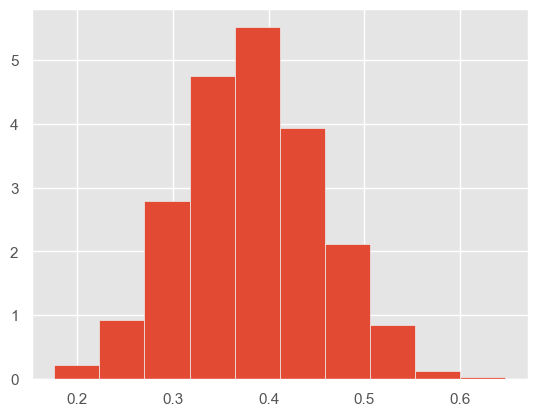

In [20]:
plt.hist(thetas[:, 2], density=True); # SOLUTION

<!-- BEGIN QUESTION -->

How do the samples compare to the two different estimates you saw in Question 1?

<!--
BEGIN QUESTION
name: q2bii
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION:**

The mean of the samples is close to the true posterior mean, lower than the trivial mean of $0.5$. The samples have a high variance.

<!-- END QUESTION -->

### 2.c Compute Posterior Mean Estimates from Samples

Fill in the function that computes posterior mean estimates for each $\theta_i$ for different parameters $\alpha, \beta$ of the prior distribution.

<!--
BEGIN QUESTION
name: q2c
manual: false
points: 1
-->

In [21]:
def empirical_posterior_mean_estimates(alpha_value, beta_value, study_df = study_df):
    """ 
    Computes posterior mean estimates of theta_i by performing approximate inference
    and then sampling from the posterior distribution:
    
    Inputs:
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
        study_df : DataFrame containing study data
        
    Output:
        posterior_estimates : (num_studies,) 1-D array of the same length as the 
            number of studies. posterior_estimates[i] contains the 
            mean estimate for theta_i based on running MCMC
    
    """
    # BEGIN SOLUTION
    model, trace = approximate_inference_MCMC(alpha_value, beta_value, study_df)
    posterior_theta_samples = trace["theta"]
    # END SOLUTION
    posterior_estimates = np.mean(posterior_theta_samples, axis = 0) # SOLUTION
    return posterior_estimates


In [22]:
grader.check("q2c")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q,

q2c results: All test cases passed!

### 2.d Plot the theoretical distribution of the posterior from Question 1 and the empirical distribution of the posterior from Question 2.

Make a 4x3 plot such that each subplot corresponds to a study. 

Each subplot should contain 2 curves and a frequency histogram:
- The PDF of the prior distribution of $\theta_i$
- The PDF of the true posterior distribution $\theta_i|X_i$ computed in closed form, as in Q.1
- The histogram of posterior samples of $\theta_i|X_i$ computed in Q.2

Make sure that you properly label each curve and histogram and give each subplot a meaningful title.

To give you a mental image of what we have in mind here is a sample subplot. Don't worry if the colors in yours are different.

![](sample_graph.png)

In [23]:
def plot_densities(alpha_value, beta_value, study_df = study_df): 
    """
    Plots for each study the prior distribution, true posterior,
    and histogram of posterior samples using MCMC
    
    Inputs:
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
        study_df : DataFrame containing study data
        
    Outputs:
        fig : Figure with 12 subplots
    """
    fig, axs = plt.subplots(4, 3)
    fig.set_figheight(15)
    fig.set_figwidth(15)

    
    theta = np.arange(0, 1.01, 0.01)
    prior = beta.pdf(theta, alpha_value, beta_value)
    
    model, trace = approximate_inference_MCMC(alpha_value, beta_value, study_df) 
    samples = trace['theta'] 
    
    for i in range(4):
        for j in range(3):
            idx = 3*i+ j
            X_i = study_df.loc[idx, 'X']
            N_i = study_df.loc[idx, 'N']
            study_name = f'Study {idx}'
            true_posterior = beta.pdf(theta, alpha_value+X_i, beta_value+N_i-X_i) 
            
            ax = axs[i, j]
            ax.plot(theta, prior, label = 'Prior')
            ax.plot(theta, true_posterior, label = "Theoretical Posterior")
            ax.hist(samples[:,idx], label = "Empirical Posterior", density=True, alpha = 0.7)
            ax.set_title(study_name)
            ax.legend()
    
    plt.tight_layout()        
    plt.show()
    return fig

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.1

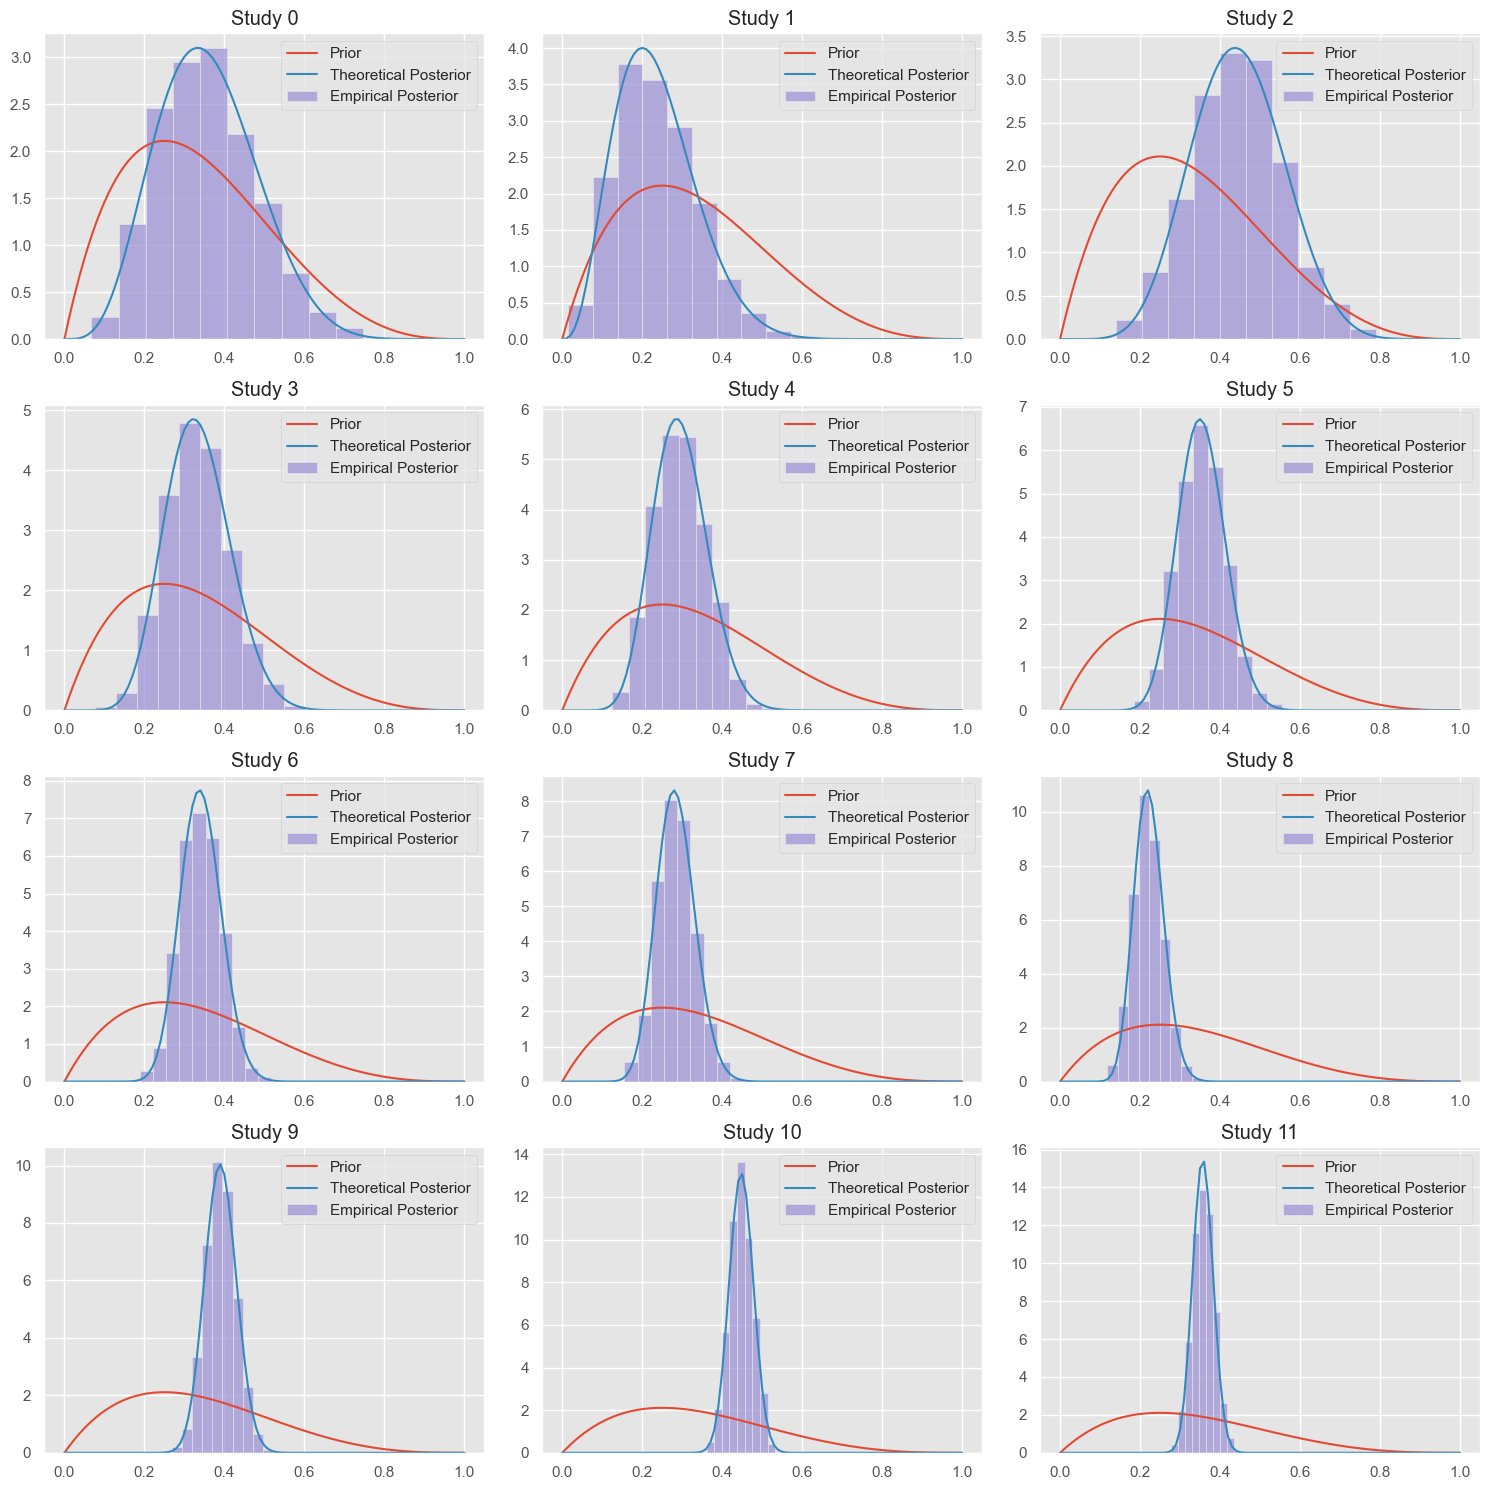

In [24]:
# Plot the resulting densities for a weak prior
fig1 = plot_densities(2, 4, study_df = study_df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.1

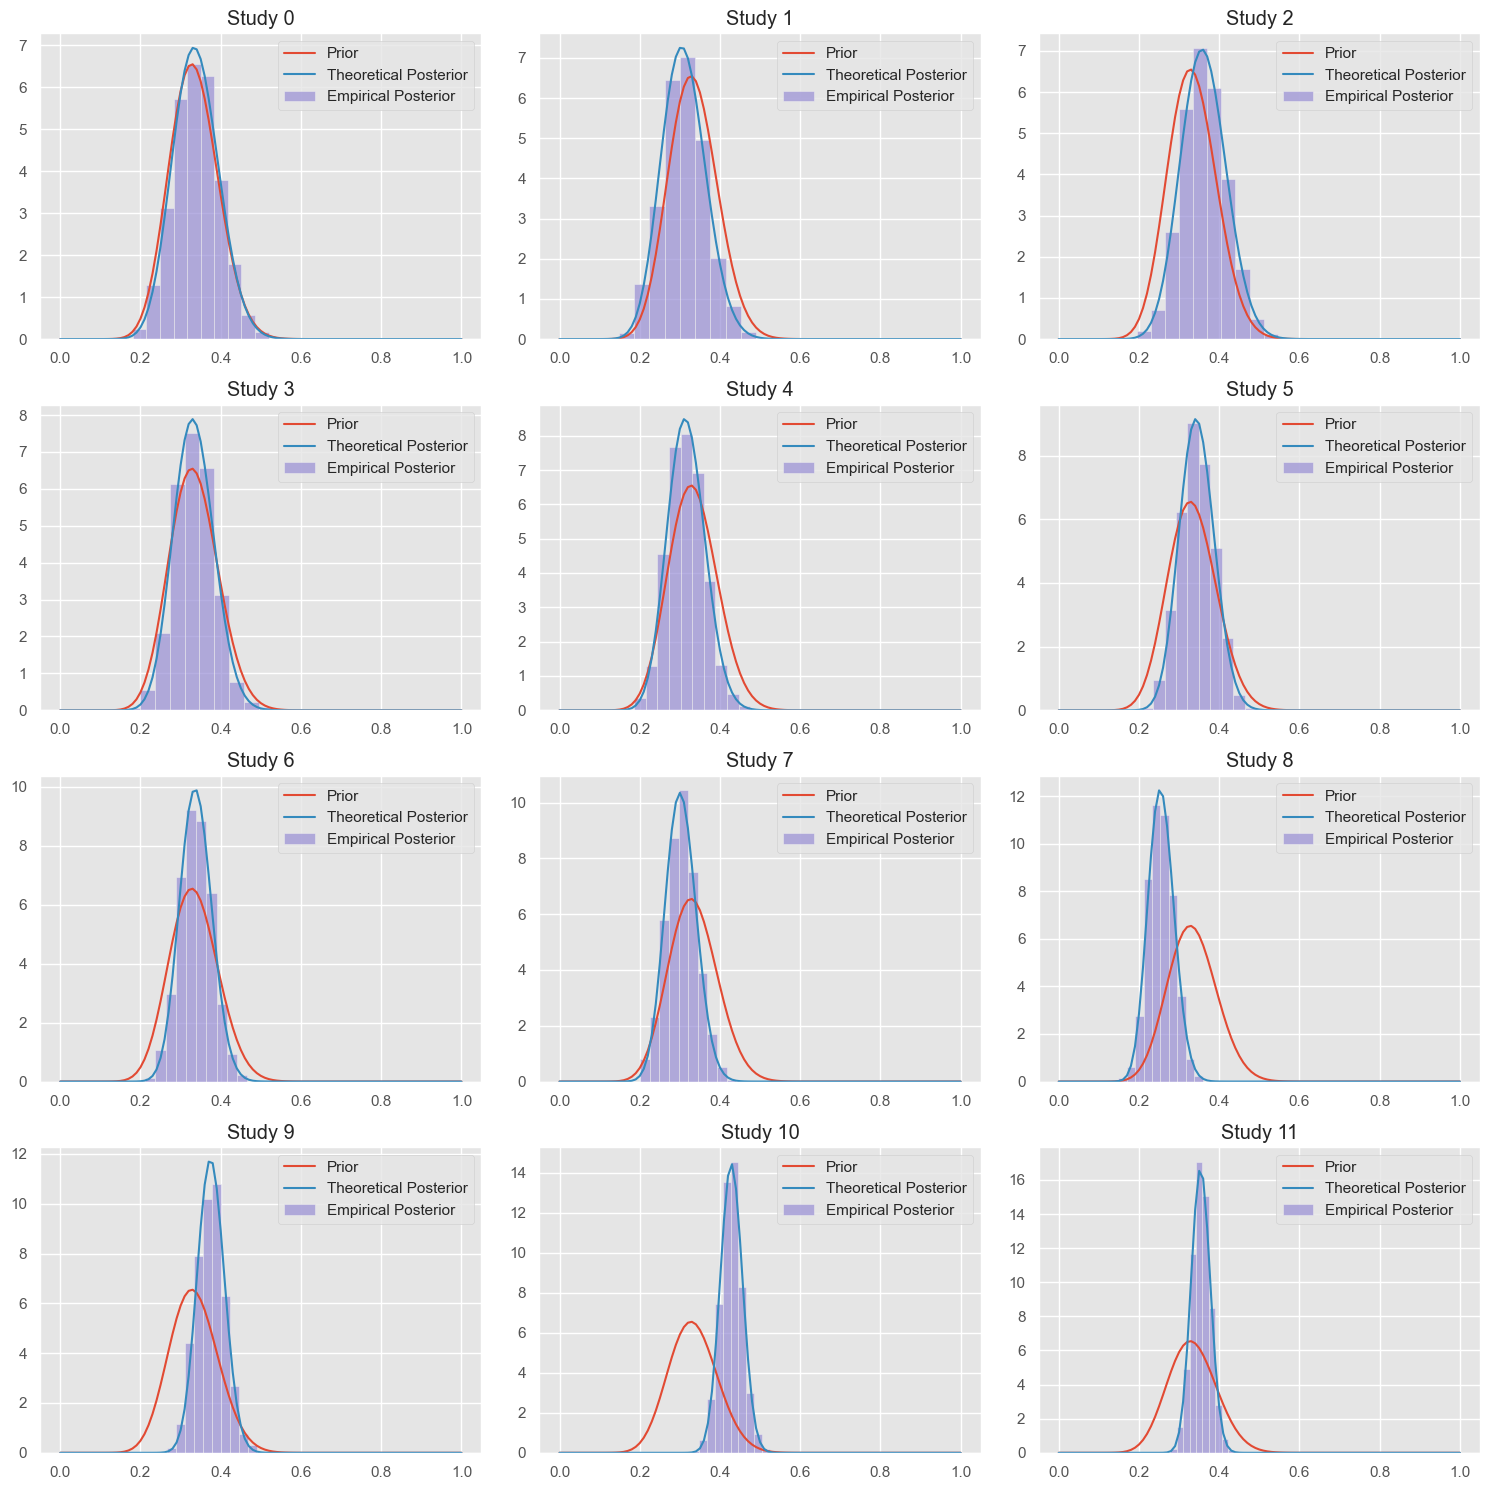

In [25]:
# Plot the resulting densities for a strong prior
fig2 = plot_densities(20, 40, study_df = study_df)

<!-- BEGIN QUESTION -->

2.d (i) Compare the curve of the theoretical distribution with the histogram of samples from the empirical posterior. Are they similar or different? Explain why.

<!--
BEGIN QUESTION
name: q2di
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION:**
The curves of the theoretical posterior distribution fits very well with the histogram of samples forming the empirical posterior.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

2.d (ii) Compare the two figures corresponding to 'weak' prior $\theta_i \sim Beta(2,4)$ and 'strong' prior  $\theta_i \sim Beta(20,40)$. How are they different? Explain why.

<!--
BEGIN QUESTION
name: q2dii
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION:**
The stronger the prior is, the closer the posterior distribution (and its empirical approximation) will be to the prior distribution. This is especially true when you look at the first few subplots of each figure, where there are fewer samples to offset the strength of the prior.

<!-- END QUESTION -->



### 2.e Approximate Inference for a More Complex Model

The previous 2 parts served as a sanity check that the approximate inference techniques used by PyMC3 can approximate the theoretical posterior. The usefulness of such packages becomes apparent when we are dealing with more complex models that don't have conjugacy properties.

Consider the following graphical model:

![](model_asymptomatic.png)

Recent studies have shown that a large fraction of COVID cases do not show symptoms, but all of the studies considered here tested only symptomatic cases. This means that the probability of testing positive (which what we observe) isn't the same as the SAR $\theta_i$! 

The estimates of the asymptomatic rate fall in the range $[0.18, 0.43]$. We assume a prior $A\sim Uniform(0.18, 0.43)$. This means that the probability that a person in a study tests positive is really $\theta_i*(1-A)$. Hence:

$$X_i|\theta_i, A \sim Binomial(N_i, \theta_i\cdot (1 - A))$$



#### Complete the `approximate_inference_asympotmatic_MCMC` function to add dependence on the asymptomatic rate:

<!--
BEGIN QUESTION
name: q2ei
manual: false
points: 1
-->

In [26]:
# TODO: complete the function
def approximate_inference_asympotmatic_MCMC(alpha_value, beta_value, study_df = study_df):
    """
    Creates and fits a PyMC3 model corresponding to the graphical model above
    
    Inputs:
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
        study_df : DataFrame containing study data
    
    Outputs: (model, trace)
    """
    with pm.Model() as model:
        theta = pm.Beta('theta', alpha=alpha_value, beta=beta_value, shape=len(study_df)) # SOLUTION
        A = pm.Uniform('A', lower = 0.18, upper = 0.43) # SOLUTION
        X = pm.Binomial('X', p=theta*(1-A), observed=study_df['X'], n=study_df['N']) # SOLUTION
        
        trace = pm.sample(500, tune=1000, target_accept=0.95, return_inferencedata=False, progressbar=False)
    return (model, trace)

In [27]:
grader.check("q2ei")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q,

q2ei results: All test cases passed!

Notice that the `trace` now contains samples for both `theta` and `A`!

Plot a histogram of the posterior estimates for $A$ if $\alpha=5$ and $\beta=10$.

<!--
BEGIN QUESTION
name: q2eii
manual: false
points: 0
-->

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, theta]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python

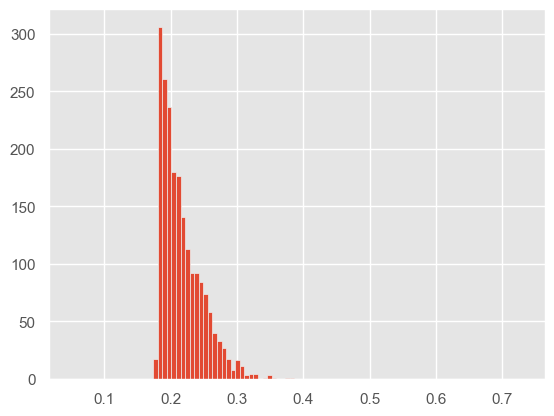

In [28]:
model, trace = approximate_inference_asympotmatic_MCMC(5, 10)
plt.hist(trace['A'], bins=np.linspace(.05, .73, 100)); # SOLUTION

<!-- BEGIN QUESTION -->

Assuming the model we defined is correct, what can you conclude about the asymptomatic rate $A$ based on the studies and the model?

<!--
BEGIN QUESTION
name: q2eiii
manual: true
points: 1
-->

_Type your answer here, replacing this text._

**SOLUTION:**

The asymptomatic rate is probably closer to 0.18 than 0.43.

<!-- END QUESTION -->

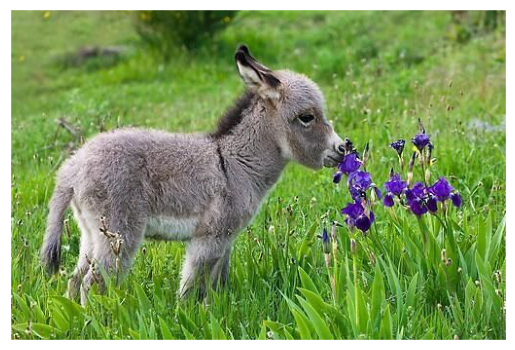

In [29]:
import matplotlib.image as mpimg
img = mpimg.imread('baby_donkey.jpg')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
plt.show()

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [31]:
grader.check_all()

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aidanmcloughlin/miniforge3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q,

q1a results: All test cases passed!

q1d results: All test cases passed!

q2a results: All test cases passed!

q2c results: All test cases passed!

q2ei results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [32]:
# Save your notebook first, then run this cell to export your submission.
grader.export()

ImportError: nbconvert is required for Otter Export but it could not be found